In [6]:
from pathlib import Path
import yaml

import torch
from torch import nn
from torch.nn import functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from matplotlib import pyplot as plt

from field_model import VectorField

from torch.func import functional_call, hessian, jacfwd, jacrev, vmap

In [7]:
# load config files for data and pipeline
with open("config.yaml", "r") as f1:
    config = yaml.full_load(f1)

# dir with trajectories Datasets
traj_dir = Path("trajectories/")
if not traj_dir.exists():
    raise FileNotFoundError("No Dataset created for given activity.")
# make dataloaders
train_loader = DataLoader(
    torch.load(traj_dir / f"jog_train.pt"),
    config["batch_size"],
    shuffle=True
)

/tmp/ipykernel_33214/1632418470.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(traj_dir / f"jog_train.pt"),


In [8]:
batch = next(iter(train_loader))
traj: torch.Tensor = batch[0]
durations: torch.Tensor = batch[1]

traj_len = traj.shape[1]
t_span = torch.arange(0, traj_len)

In [9]:
# create model
vector_field: nn.Module = VectorField(config["trajectory_dim"], config["hidden_dim"])
ode_model = NeuralODE(vector_field, solver='rk4')

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [10]:
# dict(ode_model.named_parameters())

In [ ]:
def f(params, x):
    t_eval, traj_predict = functional_call(ode_model, params, (x[:, 0, :], t_span))
    # move batch axis in front
    traj_predict = traj_predict.movedim(1, 0)

    # average loss among all phase vectors
    loss = F.mse_loss(x.flatten(end_dim=-2)[:1], (traj_predict).flatten(end_dim=-2)[:1])
    return loss

hess = hessian(f)(dict(ode_model.named_parameters()), traj)

In [7]:
for h in hess:
    print(h[0].shape)

torch.Size([20, 20, 20, 20])
torch.Size([20, 20, 20])
torch.Size([20, 20, 20, 20])
torch.Size([20, 20, 20])


In [11]:
params = list(vector_field.parameters())
hess_full = []
for i in range(len(hess)):
    param_num_dims = len(params[i].shape)
    hess_i = []

    for j in range(len(hess[0])):
        cur_hes: torch.Tensor = hess[i][j]
        cur_hes = cur_hes.flatten(start_dim=param_num_dims)
        hess_i.append(cur_hes)

    hess_i = torch.concat(hess_i, dim=-1)
    hess_i = hess_i.flatten(end_dim=param_num_dims - 1)
    hess_full.append(hess_i)

hess_full = torch.vstack(hess_full)
hess_full.shape

torch.Size([840, 840])

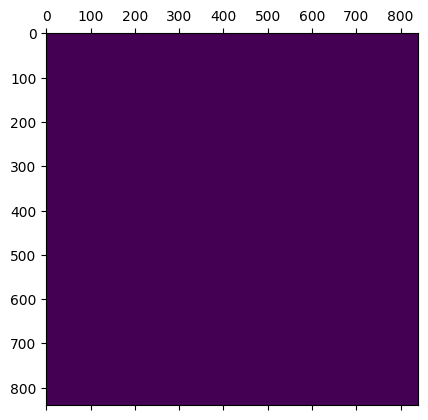

In [13]:
plt.matshow(hess_full.numpy())